# Sheet to visualize memory usage

In [1]:
from config import basic_conf as conf
from libs import ModelManager as mm
from config.constants import HyperParamKey, PathKey
import logging
import numpy as np
import pickle
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conf.init_logger(logging.DEBUG)
logger = logging.getLogger('__main__')
mgr = mm.ModelManager(mode='notebook')
mgr.load_data(mm.loaderRegister.IWSLT)

[2018-11-18 11:59:37] [INFO] Initializing Model Manager, version 0.6.4 ...
[2018-11-18 11:59:37] [INFO] 
=== Models Available ===
RNN_GRU
CNN
[2018-11-18 11:59:37] [INFO] 
=== Loaders Available ===
IWSLT
[2018-11-18 11:59:37] [INFO] 
*********** Model Manager Details ***********
-- self.hparams.voc_size = 100000
-- self.hparams.use_ft_embeddings = False
-- self.hparams.freeze_emb_vectors = False
-- self.hparams.embedding_dim = 300
-- self.hparams.hidden_size = 1000
-- self.hparams.enc_layers = 1
-- self.hparams.enc_directions = 1
-- self.hparams.dec_layers = 1
-- self.hparams.dec_directions = 1
-- self.hparams.kernel_size = 3
-- self.hparams.max_length = 100
-- self.hparams.teacher_forching_ratio = 0.5
-- self.hparams.num_epochs = 10
-- self.hparams.enc_lr = 0.01
-- self.hparams.dec_lr = 0.01
-- self.hparams.batch_size = 16
-- self.hparams.train_loop_check_freq = 100
-- self.hparams.check_early_stop = False
-- self.hparams.es_look_back = 5
-- self.hparams.es_req_prog = 0.01
-- self.hpa

### getting some sentences out of the loaded data

In [3]:
l = mgr.dataloader

In [4]:
len(l.data['source']['train'])

213377

In [5]:
print(l.data['source']['train'][1].token_indices)

print(l.data['source']['train'][1].tokens)

[2, 1760, 34429, 125, 2375, 14873, 4960, 5, 2103, 40, 8, 1694, 10, 296, 119, 2033, 119, 20849, 199, 24, 4373, 1011, 5, 193, 3333, 4246, 103, 7, 612, 3408, 5, 5525, 15, 4277, 13316, 103, 17648, 1246, 19601, 18585, 1588, 129, 716, 1175, 5, 206, 3]
['大卫', '盖罗', '通过', '潜水', '潜水艇', '拍下', '的', '影片', '把', '我们', '带到', '了', '地球', '最', '黑暗', '最', '险恶', '同时', '也', '最美', '美丽', '的', '生物', '栖息', '栖息地', '这里', '是', '海洋', '深处', '的', '峡谷', '和', '火山', '山脊', '这里', '怪诞', '适应', '适应力', '应力', '强', '而且', '数量', '惊人', '的', '生命']


## Let's initialize our model and just do an approxmiate memory usage calc

In [6]:
import torch
from libs.data_loaders.IwsltLoader import SOS_IDX, PAD_IDX
from config.basic_conf import DEVICE
from libs.models import RNN_GRU
from libs.models.RNN_GRU import _check_mem

In [7]:
m = RNN_GRU.RNN_GRU(mgr.hparams,
                   mgr.lparams,
                   mgr.cparams)

In [8]:
m.encoder

Encoder(
  (embed): Embedding(89754, 300, padding_idx=0)
  (gru): GRU(300, 1000, batch_first=True)
)

In [9]:
encoder_total = 0
for param in m.encoder.parameters():
    print(param.shape)
    print(param.dtype)
    print()
    encoder_total += param.numel()

print("Total encoder Parameter Count:", encoder_total)

torch.Size([89754, 300])
torch.float32

torch.Size([3000, 300])
torch.float32

torch.Size([3000, 1000])
torch.float32

torch.Size([3000])
torch.float32

torch.Size([3000])
torch.float32

Total encoder Parameter Count: 30832200


In [10]:
decoder_total = 0
for param in m.decoder.parameters():
    print(param.shape)
    print(param.dtype)
    print()
    decoder_total += param.numel()

print("Total decoder Parameter Count:", decoder_total)

torch.Size([69104, 300])
torch.float32

torch.Size([3000, 300])
torch.float32

torch.Size([3000, 1000])
torch.float32

torch.Size([3000])
torch.float32

torch.Size([3000])
torch.float32

torch.Size([69104, 1000])
torch.float32

torch.Size([69104])
torch.float32

Total decoder Parameter Count: 93810304


### Float32 types use 32bits or 4bytes of Memory each

In [11]:
bytes_per_param = 4

mb_usage = ((encoder_total + decoder_total) * bytes_per_param) / 1024 / 1024
print("Expect to use %.0fmb of memory:" % mb_usage)

Expect to use 475mb of memory:


In [12]:
_check_mem("Actual Usage:")

[2018-11-18 11:59:43] [INFO] at Actual Usage: - memory usage: 475.8 MB


### Let's manually step through the first trainin loop:

In [13]:
m._init_optim_and_scheduler()
criterion = m.hparams[HyperParamKey.CRITERION]
early_stop = False
best_loss = np.Inf

In [14]:
m.enc_scheduler.step(epoch=m.cur_epoch)
m.dec_scheduler.step(epoch=m.cur_epoch)
m.cur_epoch += 1

**Optimizer and Schedulers use memory on main RAM so we're not using GPU RAM**

In [15]:
_check_mem("Current Usage:")

[2018-11-18 11:59:43] [INFO] at Current Usage: - memory usage: 475.8 MB


In [16]:
for i, (src, tgt, src_lens, tgt_lens) in enumerate(l.loaders['train']):
    _check_mem("Start of batch %i")
    print(src.shape)
    print(tgt.shape)
    mm.check_mem("iteration %s " % i)
    
    batch_loss = 0
    
    m.encoder.train()
    m.decoder.train()
    m.enc_optim.zero_grad()
    m.dec_optim.zero_grad()
    batch_size = src.shape[0]
    
    enc_last_hidden = m.encoder(src, src_lens)
    dec_in = torch.full((batch_size,), SOS_IDX, device=DEVICE, dtype=torch.int64).unsqueeze(1)
    
    _check_mem("Starting Decoder")
    
    for t in range(tgt.size(1)):  # step through time/seq_len axis
        _check_mem("iteration %s of decoder recursion" % t)
        dec_in = m.decoder(dec_in, enc_last_hidden)
        batch_loss += criterion(dec_in, tgt[:, t], reduction='sum', ignore_index=PAD_IDX)
        topv, topi = dec_in.topk(1)
        dec_in = topi.detach()
        
    batch_loss /= tgt.data.gt(0).sum().float()
    _check_mem("Before back prop")
    batch_loss.backward()
    
    _check_mem("After back prop")
    
    m.enc_optim.step()
    m.dec_optim.step()
    
    _check_mem("After optimizer step")
    
    if i >= 3:
        break

[2018-11-18 11:59:43] [INFO] at Start of batch %i - memory usage: 475.8 MB
torch.Size([16, 62])
torch.Size([16, 73])
[2018-11-18 11:59:43] [INFO] at iteration 0  - memory usage: 475.8 MB
[2018-11-18 11:59:44] [INFO] at Starting Decoder - memory usage: 484.9 MB
[2018-11-18 11:59:44] [INFO] at iteration 0 of decoder recursion - memory usage: 484.9 MB
[2018-11-18 11:59:44] [INFO] at iteration 1 of decoder recursion - memory usage: 493.9 MB
[2018-11-18 11:59:44] [INFO] at iteration 2 of decoder recursion - memory usage: 502.8 MB
[2018-11-18 11:59:44] [INFO] at iteration 3 of decoder recursion - memory usage: 511.8 MB
[2018-11-18 11:59:44] [INFO] at iteration 4 of decoder recursion - memory usage: 520.8 MB
[2018-11-18 11:59:44] [INFO] at iteration 5 of decoder recursion - memory usage: 529.7 MB
[2018-11-18 11:59:44] [INFO] at iteration 6 of decoder recursion - memory usage: 538.7 MB
[2018-11-18 11:59:44] [INFO] at iteration 7 of decoder recursion - memory usage: 547.7 MB
[2018-11-18 11:59:4

[2018-11-18 11:59:45] [INFO] at iteration 9 of decoder recursion - memory usage: 1996.1 MB
[2018-11-18 11:59:45] [INFO] at iteration 10 of decoder recursion - memory usage: 2005.1 MB
[2018-11-18 11:59:45] [INFO] at iteration 11 of decoder recursion - memory usage: 2014.0 MB
[2018-11-18 11:59:45] [INFO] at iteration 12 of decoder recursion - memory usage: 2023.0 MB
[2018-11-18 11:59:45] [INFO] at iteration 13 of decoder recursion - memory usage: 2032.0 MB
[2018-11-18 11:59:45] [INFO] at iteration 14 of decoder recursion - memory usage: 2040.9 MB
[2018-11-18 11:59:45] [INFO] at iteration 15 of decoder recursion - memory usage: 2049.9 MB
[2018-11-18 11:59:45] [INFO] at iteration 16 of decoder recursion - memory usage: 2058.9 MB
[2018-11-18 11:59:45] [INFO] at iteration 17 of decoder recursion - memory usage: 2067.8 MB
[2018-11-18 11:59:45] [INFO] at iteration 18 of decoder recursion - memory usage: 2076.8 MB
[2018-11-18 11:59:45] [INFO] at iteration 19 of decoder recursion - memory usage:

[2018-11-18 11:59:46] [INFO] at iteration 43 of decoder recursion - memory usage: 2300.9 MB
[2018-11-18 11:59:46] [INFO] at iteration 44 of decoder recursion - memory usage: 2309.9 MB
[2018-11-18 11:59:46] [INFO] at iteration 45 of decoder recursion - memory usage: 2318.9 MB
[2018-11-18 11:59:46] [INFO] at iteration 46 of decoder recursion - memory usage: 2327.8 MB
[2018-11-18 11:59:46] [INFO] at iteration 47 of decoder recursion - memory usage: 2336.8 MB
[2018-11-18 11:59:46] [INFO] at iteration 48 of decoder recursion - memory usage: 2345.8 MB
[2018-11-18 11:59:46] [INFO] at iteration 49 of decoder recursion - memory usage: 2354.7 MB
[2018-11-18 11:59:46] [INFO] at iteration 50 of decoder recursion - memory usage: 2363.7 MB
[2018-11-18 11:59:46] [INFO] at iteration 51 of decoder recursion - memory usage: 2372.7 MB
[2018-11-18 11:59:46] [INFO] at iteration 52 of decoder recursion - memory usage: 2381.6 MB
[2018-11-18 11:59:46] [INFO] at iteration 53 of decoder recursion - memory usage

**The Adam Optimizer uses about 1GB of memory here to compute the gradient estimates**

## What about the compute_loss function, which goes agains the whole training set?

In [17]:
loader = l.loaders['train']
m.encoder.eval()
m.decoder.eval()
loss = 0
mem_used_list = []
tensor_length_list = []
current_t = []
for i, (src, tgt, slen, tlen) in enumerate(loader):
    batch_loss = 0
    batch_size = src.size()[0]
    # encoding
    enc_last_hidden = m.encoder(src, slen)
    # decoding
    dec_in = torch.LongTensor([SOS_IDX] * batch_size).unsqueeze(1).to(DEVICE)
    for t in range(tgt.size(1)):  # seq_len axis
        # tensor length
        tensor_length_list.append(tgt.size(1)) 
        
        # which time step?
        current_t.append(t)
            
        # memory:
        mem_used = torch.cuda.memory_allocated(int(str(DEVICE)[-1])) / 1024 / 1024
        mem_used_list.append(mem_used)
        
        
        dec_out = m.decoder(dec_in, enc_last_hidden)
        batch_loss += criterion(dec_out, tgt[:, t], reduction='sum',
                                ignore_index=PAD_IDX)
        topv, topi = dec_out.topk(1)
        dec_in = topi.detach()
    batch_loss /= tgt.data.gt(0).sum().float()
    loss += batch_loss.item()
loss /= len(loader)

RuntimeError: CUDA error: out of memory

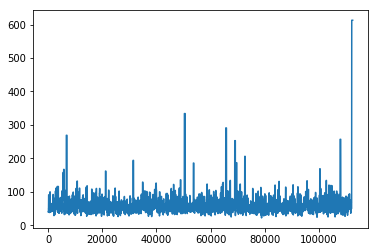

In [18]:
plt.plot(tensor_length_list)
plt.show()

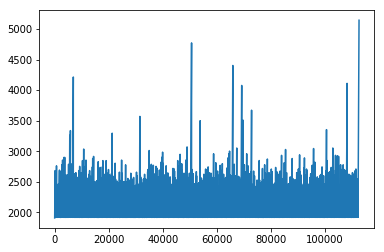

In [19]:
plt.plot(mem_used_list)
plt.show()

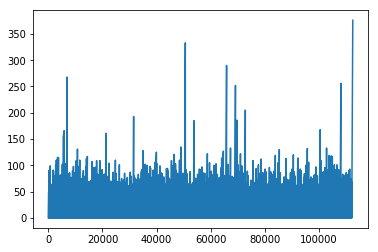

In [20]:
plt.plot(current_t)
plt.show()

In [22]:
# we can fit maximum this many in this scenario
current_t[-1]

376

In [24]:
# need to fit this many:
tensor_length_list[-1]

613

In [28]:
# each time step adds this much to memory:
mem_used_list[-1] - mem_used_list[-2], mem_used_list[-2] - mem_used_list[-3]

(8.59912109375, 8.59912109375)

### Why?

In [36]:
dec_out.shape # batch x out vocab size

torch.Size([16, 69104])

In [42]:
dec_out_mem = dec_out.shape[0] * dec_out.shape[1] * 4 / 1024 / 1024
dec_out_mem

4.2177734375

In [48]:
dec_out_mem * 2

8.435546875